In [2]:
from os import walk
import numpy as np
from matplotlib import pyplot as plt
from ase.units import _e, _hplanck, kB

G0 = 2. * _e**2 / _hplanck

In [3]:
def fermidistribution(energy, kt):
    # fermi level is fixed to zero
    # energy can be a single number or a list
    assert kt >= 0., 'Negative temperature encountered!'

    if kt == 0:
        if isinstance(energy, float):
            return int(energy / 2. <= 0)
        else:
            return (energy / 2. <= 0).astype(int)
    else:
        return 1. / (1. + np.exp(energy / kt))


def current(bias, energy, transmission, temperature=300, unit='uA',shift=0.0):
    """Get the current in uA."""
    if not isinstance(bias, (int, float)):
        bias = bias[np.newaxis]
        energy = energy[:, np.newaxis]
        transmission = transmission[:, np.newaxis]

    fl = fermidistribution(energy - bias / 2., kB * temperature)
    fr = fermidistribution(energy + bias / 2., kB * temperature)
    return G0 * np.trapz((fl - fr) * transmission, x=energy, axis=0) * 1e6, fl, fr  # uA

In [4]:
temp = 11.6
kt = kB*temp
E, T = np.load("../reference/ET_dmft.npy")
dV = 0.001
Vmin = 0
Vmax = 0.1
bias = np.arange(Vmin, Vmax + dV / 2., dV)

In [5]:
I_trieste_loaded = np.load("../Angelo_dmft/eta_1e-2/nbath7/Jbias_landauer.npy")

(-0.2, 0.2)

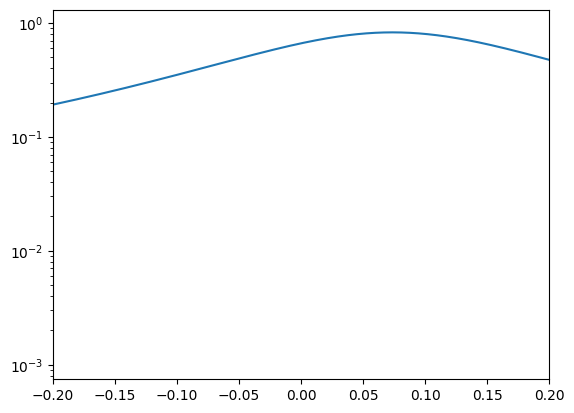

In [6]:
E_dft, T_dft = np.load("../Angelo_dmft/eta_1e-3/nbath7/dft_transmission.npy")
plt.plot(E_dft, T_dft)
plt.yscale("log")
plt.xlim(-0.2,0.2)

/tmp/ipykernel_4130224/1538004712.py:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,1)


Text(0, 0.5, 'Transmission')

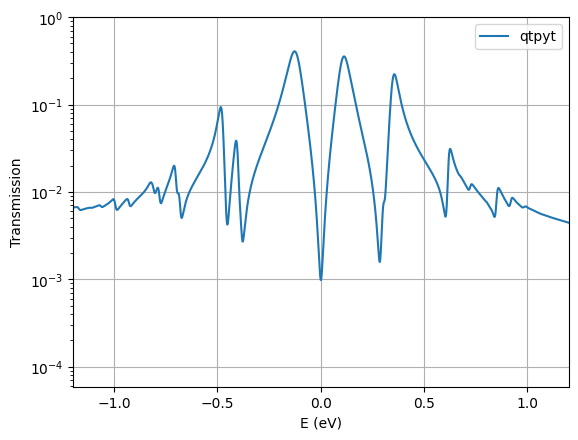

In [7]:
ref = np.load("../Angelo_dmft/eta_1e-2/nbath7/Te_landauer.npy")
E_qtpyt, T_qtpyt = np.load("../Angelo_dmft/eta_1e-3/nbath7/dmft_transmission_with_dcc.npy")
E_qtpyt2, T_qtpyt2 = np.load("../Angelo_dmft/eta_1e-2/nbath7/dmft_transmission_with_dcc.npy")
# plt.plot(E_dft,T_dft,label="DFT")
plt.plot(E_qtpyt2-0.1,T_qtpyt2,label="qtpyt")
# plt.plot(ref[:,0],ref[:,1],label="trieste")
# plt.plot(E,T,label="arxiv")
plt.grid(True)
plt.yscale("log")
plt.xlim(-1.2,1.2)
plt.ylim(0,1)
plt.legend()
plt.xlabel("E (eV)")
plt.ylabel("Transmission")

In [8]:
bias2 = np.arange(0.0,2.0,0.01)
I_trieste, fl_trieste, fr_trieste = current(bias2, ref[:,0],ref[:,1], temperature=temp)
I_qtpyt, fl_qtpyt, fr_qtpyt = current(bias2, E_qtpyt, T_qtpyt, temperature=temp)
I_qtpyt2, fl_qtpyt2, fr_qtpyt2 = current(bias2, E_qtpyt2, T_qtpyt2, temperature=temp)

/tmp/ipykernel_4130224/102225856.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


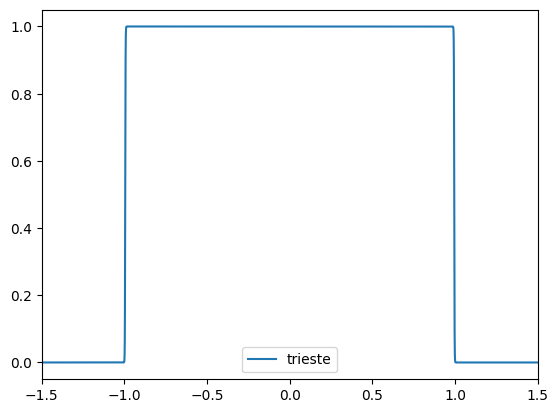

In [9]:
plt.plot(ref[:,0],(fl_trieste[:,199]-fr_trieste[:,199]),label="trieste")
# plt.plot(E_qtpyt,fl_qtpyt[:,100]-fr_qtpyt[:,100],'.',label="qtpyt")
# plt.plot(E,fl_arxiv[:,100]-fr_arxiv[:,100],'.',label="arxiv")
plt.xlim(-1.5,1.5)
plt.legend()

Text(0, 0.5, 'Current')

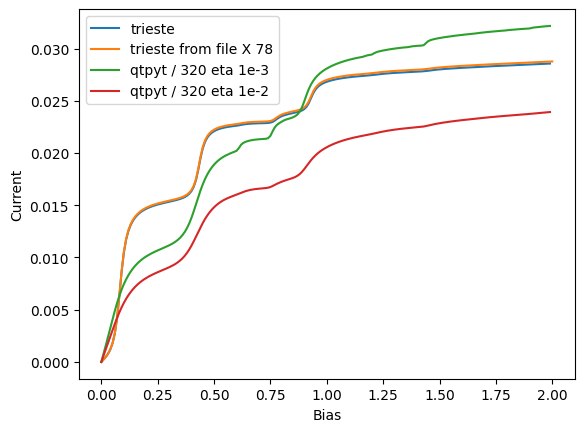

In [10]:
plt.plot(bias2,I_trieste,label="trieste")
plt.plot(I_trieste_loaded[:,0],-1*I_trieste_loaded[:,1]*78,label="trieste from file X 78")
plt.plot(bias2,I_qtpyt/320,label="qtpyt / 320 eta 1e-3")
plt.plot(bias2,I_qtpyt2/320,label="qtpyt / 320 eta 1e-2")
plt.legend()
plt.xlabel("Bias")
plt.ylabel("Current")
# plt.xlim(0,0.1)
# plt.yscale("log")

/tmp/ipykernel_4130224/102225856.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


(0.0, 8e-05)

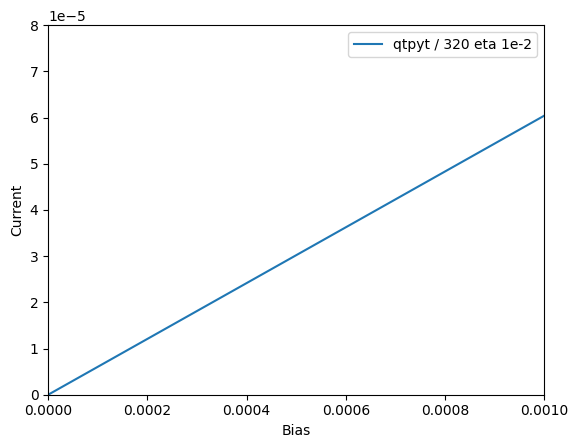

In [11]:
bias2 = np.arange(0.0,2.0,0.01)
I_qtpyt2, fl_qtpyt2, fr_qtpyt2 = current(bias2, E_qtpyt2, T_qtpyt2, temperature=temp)
plt.plot(bias2,I_qtpyt2/320,label="qtpyt / 320 eta 1e-2")
plt.legend()
plt.xlabel("Bias")
plt.ylabel("Current")
plt.xlim(0,0.001)
plt.ylim(0,0.00008)


/tmp/ipykernel_4130224/102225856.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


Text(0, 0.5, 'Current')

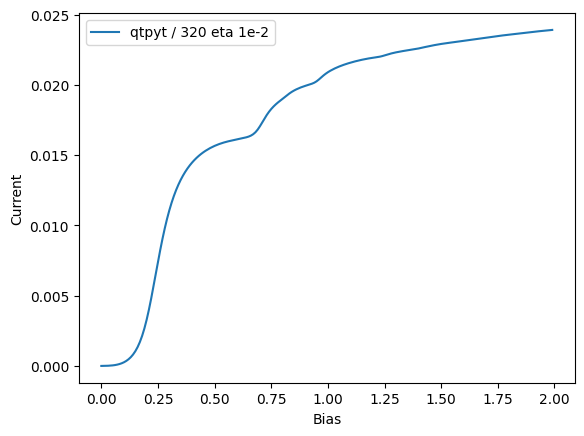

In [12]:
E_shifted = E_qtpyt2 - 0.1
np.save("shifted_transmission_qtpyt.npy", (E_shifted, T_qtpyt2))
E_shifted, T_shifted = np.load("shifted_transmission_qtpyt.npy", allow_pickle=True)
I_qtpyt2, fl_qtpyt2, fr_qtpyt2 = current(bias2, E_shifted, T_shifted, temperature=temp)
plt.plot(bias2,I_qtpyt2/320,label="qtpyt / 320 eta 1e-2")
plt.legend()
plt.xlabel("Bias")
plt.ylabel("Current")

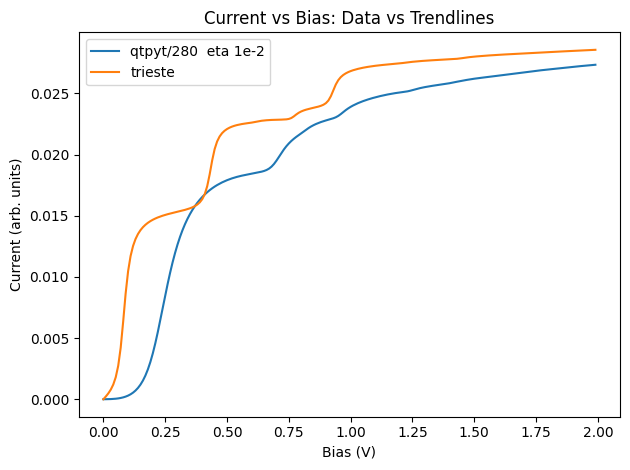

In [14]:
linear_coeffs = np.polyfit(bias2, I_qtpyt2 , deg=1)
linear_trend = np.poly1d(linear_coeffs)

cubic_coeffs = np.polyfit(bias2, I_qtpyt2 , deg=3)
cubic_trend = np.poly1d(cubic_coeffs)

plt.plot(bias2, I_qtpyt2/280 , label="qtpyt/280  eta 1e-2")
plt.plot(bias2,I_trieste,label="trieste")

# plt.plot(bias2, linear_trend(bias2), '--', label="Linear trend")
# plt.plot(bias2, cubic_trend(bias2), ':', label="Cubic trend")

plt.legend()
plt.xlabel("Bias (V)")
plt.ylabel("Current (arb. units)")
plt.title("Current vs Bias: Data vs Trendlines")
plt.tight_layout()
plt.show()

/tmp/ipykernel_4130224/102225856.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


[ 9.79205079e+01 -2.98831704e+00  1.53500046e-01 -3.83466266e-04]


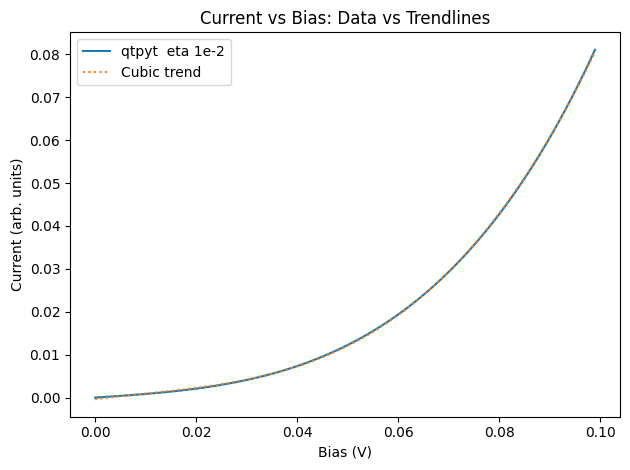

In [24]:
bias3 = np.arange(0,0.1,0.001)

I_qtpyt3, fl_qtpyt3, fr_qtpyt3 = current(bias3, E_shifted, T_shifted, temperature=temp)

linear_coeffs = np.polyfit(bias3, I_qtpyt3 , deg=1)
linear_trend = np.poly1d(linear_coeffs)

cubic_coeffs = np.polyfit(bias3, I_qtpyt3 , deg=3)
cubic_trend = np.poly1d(cubic_coeffs)
print(cubic_coeffs)
plt.plot(bias3, I_qtpyt3 , label="qtpyt  eta 1e-2")
# plt.plot(bias3,I_trieste,label="trieste")

# plt.plot(bias3, linear_trend(bias3), '--', label="Linear trend")
plt.plot(bias3, cubic_trend(bias3), ':', label="Cubic trend")

plt.legend()
plt.xlabel("Bias (V)")
plt.ylabel("Current (arb. units)")
plt.title("Current vs Bias: Data vs Trendlines")
plt.tight_layout()
plt.show()

In [26]:
import numpy as np
from numpy.linalg import lstsq

def fit_cubic_zero_intercept(bias: np.ndarray, current: np.ndarray) -> np.ndarray:
    """
    Fit a cubic polynomial to I–V data with the constraint that the intercept is zero.

    This function solves the least squares problem for a cubic polynomial of the form:

        I(V) = a₃·V³ + a₂·V² + a₁·V

    where:
    - `I(V)` is the current as a function of voltage `V` (bias),
    - The constant (bias-independent) term is explicitly excluded to enforce I(0) = 0.

    The fit is performed by constructing a design matrix `X`:
        X = [V³, V², V]

    and solving the linear system:
        X · c = I

    where:
    - `c = [a₃, a₂, a₁]ᵀ` are the polynomial coefficients,
    - `I` is the measured current at each bias point.

    Parameters
    ----------
    bias : np.ndarray
        1D array of voltage bias values.
    current : np.ndarray
        1D array of current values corresponding to each bias point.

    Returns
    -------
    coeffs : np.ndarray
        Array of coefficients [a₃, a₂, a₁] for the constrained cubic fit.

    Notes
    -----
    - This is a constrained fit where the zero-bias current is forced to be zero.
    """
    X = np.column_stack([bias**3, bias**2, bias])
    coeffs = lstsq(X, current, rcond=None)[0]
    return coeffs


/tmp/ipykernel_4130224/102225856.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


coeffs [279.8159964  -37.79609579   1.64910712]


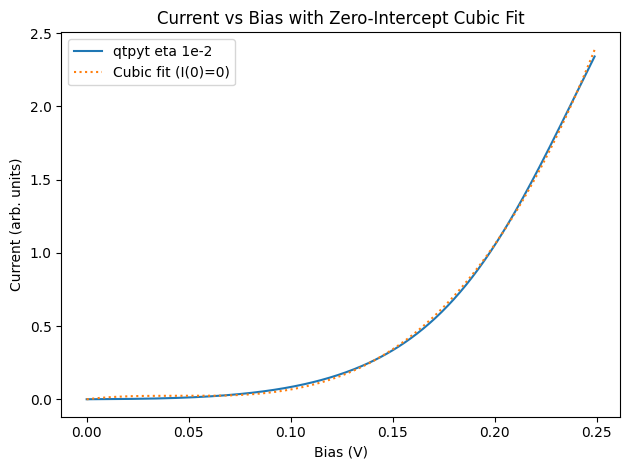

In [40]:
bias3 = np.arange(0,0.25,0.001)
I_qtpyt3, fl_qtpyt3, fr_qtpyt3 = current(bias3, E_shifted, T_shifted, temperature=temp)

coeffs_cubic_constrained = fit_cubic_zero_intercept(bias3, I_qtpyt3)
print("coeffs",coeffs_cubic_constrained)
I_fit_constrained = bias3**3 * coeffs_cubic_constrained[0] + \
                    bias3**2 * coeffs_cubic_constrained[1] + \
                    bias3    * coeffs_cubic_constrained[2]

plt.plot(bias3, I_qtpyt3, label="qtpyt eta 1e-2")
plt.plot(bias3, I_fit_constrained, ':', label="Cubic fit (I(0)=0)")
plt.xlabel("Bias (V)")
plt.ylabel("Current (arb. units)")
plt.title("Current vs Bias with Zero-Intercept Cubic Fit")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
bias_endpoints = [0.001, 0.005, 0.008, 0.01, 0.05, 0.1, 0.2, 0.25]

results = []

for endpoint in bias_endpoints:
    bias = np.arange(0, endpoint + 1e-9, 0.001)
    I_qtpyt, _, _ = current(bias, E_shifted, T_shifted, temperature=temp)
    coeffs = fit_cubic_zero_intercept(bias, I_qtpyt)
    results.append([f"{endpoint:.3f}"] + [f"{c:.4e}" for c in coeffs])

print(f"{'Bias End':>8} | {'a₃ (V³)':>12} | {'a₂ (V²)':>12} | {'a₁ (V)':>12}")
print("-" * 52)

for row in results:
    print(f"{row[0]:>8} | {row[1]:>12} | {row[2]:>12} | {row[3]:>12}")

Bias End |      a₃ (V³) |      a₂ (V²) |       a₁ (V)
----------------------------------------------------
   0.001 |   7.8832e-08 |   7.8832e-05 |   7.8832e-02
   0.005 |   6.3795e+01 |  -2.9439e-04 |   7.8768e-02
   0.008 |   6.3906e+01 |  -1.1713e-03 |   7.8770e-02
   0.010 |   6.4006e+01 |  -2.2513e-03 |   7.8773e-02
   0.050 |   7.0737e+01 |  -2.7201e-01 |   8.1356e-02
   0.100 |   9.5242e+01 |  -2.4906e+00 |   1.2668e-01
   0.200 |   2.4642e+02 |  -3.0001e+01 |   1.2536e+00
   0.250 |   2.7844e+02 |  -3.7403e+01 |   1.6245e+00


/tmp/ipykernel_4130224/102225856.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))


In [46]:
# Bias endpoints to try
bias_endpoints = [0.001, 0.002, 0.003, 0.004, 0.005, 0.008, 0.01, 0.05, 0.1, 0.2, 0.25]

# Store rows of results
results = []

for endpoint in bias_endpoints:
    bias = np.arange(0, endpoint + 1e-9, 0.001)  # include endpoint
    I_qtpyt, _, _ = current(bias, E_shifted, T_shifted, temperature=temp)
    coeffs = fit_cubic_zero_intercept(bias, I_qtpyt)
    a3, a2, a1 = coeffs
    sum_abs = abs(a3) + abs(a2) + abs(a1)

    w_cubic = abs(a3) / sum_abs * 100
    w_quad = abs(a2) / sum_abs * 100
    w_linear = abs(a1) / sum_abs * 100

    results.append([
        f"{endpoint:.3f}", f"{a3:.4e}", f"{a2:.4e}", f"{a1:.4e}",
        f"{w_cubic:.2f}%", f"{w_quad:.2f}%", f"{w_linear:.2f}%"
    ])


headers = [
    "Bias End", "a₃ (V³)", "a₂ (V²)", "a₁ (V)",
    "Cubic %", "Quad %", "Linear %"
]

print(f"{'Bias End':>8} | {'a₃ (V³)':>12} | {'a₂ (V²)':>12} | {'a₁ (V)':>12} | {'Cubic %':>8} | {'Quad %':>8} | {'Linear %':>9}")
for row in results:
    print(f"{row[0]:>8} | {row[1]:>12} | {row[2]:>12} | {row[3]:>12} | {row[4]:>8} | {row[5]:>8} | {row[6]:>9}")


Bias End |      a₃ (V³) |      a₂ (V²) |       a₁ (V) |  Cubic % |   Quad % |  Linear %
   0.001 |   7.8832e-08 |   7.8832e-05 |   7.8832e-02 |    0.00% |    0.10% |    99.90%
   0.002 |   5.7338e-04 |   1.9118e-01 |   7.8641e-02 |    0.21% |   70.70% |    29.08%
   0.003 |   6.3748e+01 |  -6.3384e-05 |   7.8768e-02 |   99.88% |    0.00% |     0.12%
   0.004 |   6.3768e+01 |  -1.5159e-04 |   7.8768e-02 |   99.88% |    0.00% |     0.12%
   0.005 |   6.3795e+01 |  -2.9439e-04 |   7.8768e-02 |   99.88% |    0.00% |     0.12%
   0.008 |   6.3906e+01 |  -1.1713e-03 |   7.8770e-02 |   99.88% |    0.00% |     0.12%
   0.010 |   6.4006e+01 |  -2.2513e-03 |   7.8773e-02 |   99.87% |    0.00% |     0.12%
   0.050 |   7.0737e+01 |  -2.7201e-01 |   8.1356e-02 |   99.50% |    0.38% |     0.11%
   0.100 |   9.5242e+01 |  -2.4906e+00 |   1.2668e-01 |   97.33% |    2.55% |     0.13%
   0.200 |   2.4642e+02 |  -3.0001e+01 |   1.2536e+00 |   88.74% |   10.80% |     0.45%
   0.250 |   2.7844e+02 |  -3.74

/tmp/ipykernel_4130224/102225856.py:12: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(energy / kt))
